# Optimizing Neural Networks for CIFAR-10 Image Classiﬁcation

## Importing Libraries

In [1]:
from tensorflow import keras
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

## Mounting Google Drive

Since the project is done mostly in Google Colab, it will be helpful to connect Google Drive to be able to save and load files from there.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset

This notebook will explore the CIFAR-10 dataset, which contains 60,000 32x32 color images across 10 different classes. We will load the dataset using Keras, separating it into training and testing sets for later use in image classification tasks.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Let's examine the shape of our training and testing data to confirm the dimensions of the images and the number of samples.

In [ ]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Data preprocesing

Now that we've loaded and explored the basic structure of our data, we'll move on to preprocessing. This crucial step involves preparing the data in a way that optimizes it for use in machine learning models, potentially improving model performance and training efficiency.

### Checking missing values

It's good practice to check for missing values in our dataset. While unlikely in a well-curated dataset like CIFAR-10, identifying and handling missing data is essential to prevent potential issues during model training.

In [ ]:
nan_count = np.isnan(X_train).sum()
print("Number of missing values in X_train:", nan_count)

Number of missing values in X_train: 0


### Scaling the data

After checking for missing values, the next crucial step is to scale the pixel values of our images. Currently, these values range from 0 to 255. We will divide them by 255 to get the value from 0 to 1 for each pixel. Neural networks tend to converge much faster when features are on similar scales. Scaling prevents features with larger values from dominating the learning process. It is especially important for Deep Neural Networks and Deep and Wide Neural Networks.

In [4]:
X_train_scaled = X_train.astype('float32') / 255.0
X_test_scaled = X_test.astype('float32') / 255.0

### Encoding the Labels

Our labels now have values from 0 to 9. Let's confirm it.

In [ ]:
unique_labels = np.unique(y_train)
print("Label values in CIFAR-10:", unique_labels)

Label values in CIFAR-10: [0 1 2 3 4 5 6 7 8 9]


We could just leave the labels like this, but such representation might mistakenly imply an ordinal relationship between classes (e.g., suggesting that class 2 is "greater" than class 1), which is not true for CIFAR-10. So we will encode them, using one-hot encoding. It will ensure that all labels are treated equally.

In [5]:
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)


### Visualizing some images

To get a better understanding of the images we're working with, let's visualize a random selection of images from the training set along with their corresponding labels.

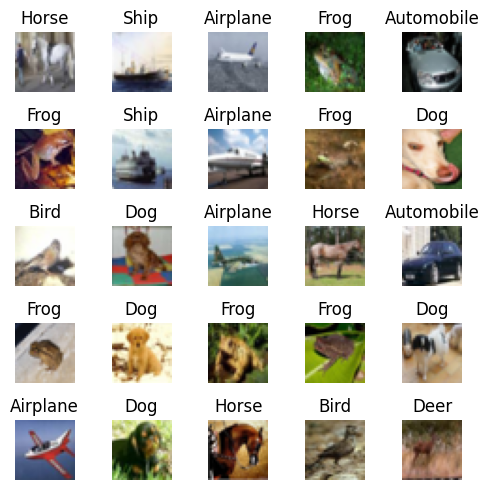

In [ ]:
# CIFAR-10 class labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Set the random seed for reproducibility
random_state = 42
np.random.seed(random_state)

# Select 25 random images
num_images = 25
indices = np.random.choice(X_train.shape[0], num_images, replace=False)
selected_images = X_train[indices]
selected_labels = y_train[indices]

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[selected_labels[i][0]])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Building Neural Network models

Now that we have preprocessed our data, we are ready to build and train our neural network models. We will start by constructing a deep neural network (DNN), then we will implement a deep and wide neural network and finally a convolutional neural network (CNN). Each model will be trained on the preprocessed training data and evaluated on the test data to compare their performance.

### Deep Neural Network (DNN)

We will begin by building a deep neural network (DNN) model. This model will feature a deep architecture with 20 hidden layers, each containing 100 neurons. To ensure proper weight initialization, we will use He initialization. For the activation function, we'll employ the Swish activation. The output layer will use a softmax activation to produce probability scores for each of the 10 CIFAR-10 classes.

For optimization, we'll utilize the Nadam optimizer, which combines the benefits of Adam and Nesterov momentum, often leading to faster convergence and improved generalization. We'll also incorporate early stopping during training to prevent overfitting and automatically stop training when the model's performance on a validation set is not changing significantly.

#### Learning Rate Exploration

We will experiment with learning rates to find the optimal one. So let's define the list of learning rates to explore, as well as the variables to track the best validation accuracy and the best learning rate.

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

best_val_accuracy = 0
best_lr = None

#### Creating the DNN Model

Let's define a separate function to create a DNN model. This will make the code more structured and easier to reuse later.

In [ ]:
def dnn_model(hidden_layers, number_of_neurons):
    dnn = keras.models.Sequential()

    dnn.add(keras.layers.Input(shape=(32, 32, 3)))
    dnn.add(keras.layers.Flatten())

    for _ in range(hidden_layers):
        dnn.add(keras.layers.Dense(
            units=number_of_neurons,
            activation='swish',
            kernel_initializer='he_normal'
        ))

    dnn.add(keras.layers.Dense(10, activation='softmax'))
    return dnn

#### Defining EarlyStopping and ModelCheckpoint callbacks

Here, we define the callbacks that will be used during the training process. We define an `EarlyStopping` callback to halt training if the validation accuracy does not improve for a certain number of epochs and a `ModelCheckpoint` callback to save the best-performing model based on validation accuracy.

In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/dnn.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

#### Train the model with different learning rates

In [ ]:
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Create the model
    dnn = dnn_model(hidden_layers=20, number_of_neurons=100)

    # Compile the model with the current learning rate
    dnn.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Nadam(learning_rate=lr),
        metrics=['accuracy']
    )

    # Train the model
    history_dnn = dnn.fit(
        X_train_scaled, y_train_onehot,
        validation_split=0.2,
        epochs=100,
        callbacks=[early_stopping, checkpoint]
    )

    # Get the best validation accuracy from the training history
    val_acc = max(history_dnn.history['val_accuracy'])
    print(f"Final Validation Accuracy: {val_acc:.4f}\n")

    # Update the best learning rate and accuracy if necessary
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_lr = lr

Training with learning rate: 0.1
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.1000 - loss: 3029600768.0000 - val_accuracy: 0.0952 - val_loss: 2.3124
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1018 - loss: 2.3134 - val_accuracy: 0.0980 - val_loss: 2.3056
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1010 - loss: 2.3137 - val_accuracy: 0.0980 - val_loss: 2.3155
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0980 - loss: 2.3145 - val_accuracy: 0.0997 - val_loss: 2.3140
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0976 - loss: 2.3151 - val_accuracy: 0.1025 - val_loss: 2.3101
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1010 - loss: 2.3142 - val_accuracy: 0.1025 - val_loss: 2.3164
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0998 - loss: 2.3138 - val_accuracy: 0.0977 - val_loss: 2.3134
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━

#### Training results

Let's look at the best validation accuracy and the learning rate that gave it.

In [ ]:
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Best Learning Rate: 0.0001
Best Validation Accuracy: 0.4983


We can see that the best validation accuracy is 49.8%, which is not as good as we hope to get. But there is another reason to be concerned about here, besides low validation accuracy. If we look at the detailed output from previous step, we can see that training accuracy for this learing rate went up to 68.6%, when validation accuracy plateaued around 49%. This clearly indicates that our model is overfitting, so let's try to improve its performance and prevent overfitting.

#### Batch Normalization

Now, we will enhance our model further by incorporating Batch Normalization. Batch Normalization is the process of adding an operation in the model
just before or after the activation function of each hidden layer. The operation lets the model learn the optimal scale and mean of each of
the layer's inputs. Let's add Batch Normalization layers after each hidden layer in our DNN and then retrain the model to observe the impact on performance.

In [ ]:
def dnn_model_batch_normalization(hidden_layers, number_of_neurons):
    dnn = keras.models.Sequential()

    dnn.add(keras.layers.Input(shape=(32, 32, 3)))
    dnn.add(keras.layers.Flatten())

    dnn.add(keras.layers.BatchNormalization())

    for _ in range(hidden_layers):
        dnn.add(keras.layers.Dense(
            units=number_of_neurons,
            activation=None,
            kernel_initializer='he_normal'
        ))
        dnn.add(keras.layers.BatchNormalization())
        dnn.add(keras.layers.Activation('swish'))

    dnn.add(keras.layers.Dense(10, activation='softmax'))
    return dnn

Now, let's train the model with Batch Normalization and see the results. We will use the fixed learning rate of 0.0001 now, since it gave the best results before.

In [ ]:
# Create the model
dnn_batch_normalization = dnn_model_batch_normalization(hidden_layers=20, number_of_neurons=100)

# Compile the model
dnn_batch_normalization.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Train the model
history_dnn_batch_normalization = dnn_batch_normalization.fit(
    X_train_scaled, y_train_onehot,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

# Get the best validation accuracy from the training history
val_acc = max(history_dnn_batch_normalization.history['val_accuracy'])
print(f"Final Validation Accuracy: {val_acc:.4f}\n")

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.1221 - loss: 2.4200 - val_accuracy: 0.1803 - val_loss: 2.4535
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2012 - loss: 2.1694 - val_accuracy: 0.2588 - val_loss: 2.1223
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2600 - loss: 1.9940 - val_accuracy: 0.3169 - val_loss: 1.9132
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3183 - loss: 1.8551 - val_accuracy: 0.3599 - val_loss: 1.7813
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3515 - loss: 1.7823 - val_accuracy: 0.3903 - val_loss: 1.7115
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3830 - loss: 1.7240 - val_accuracy: 0.4126 - val_loss: 1.6452
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4026 - loss: 1.6549 - val_accuracy: 0.4277 - val_loss: 1.6012
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4208 - loss:

We can see that validation accuracy is now about 46.9%, which is slightly lower than what we had without Batch Normalization. However, the model is not overfitting anymore, which is a good sign.

Let's save our model in case we want to use it later.

In [ ]:
dnn_batch_normalization.save('/content/drive/My Drive/dnn_batch_normalization.keras')

#### Dropout

We can take further steps to enhance our model's robustness and prevent overfitting. In this section, we will introduce dropout, a regularization technique that randomly deactivates a fraction of neurons during each training iteration. This helps prevent the network from relying too heavily on any specific neuron or set of features, promoting better generalization to unseen data. We will add dropout layers after the batch normalization layers in our DNN.

In [17]:
def dnn_model_dropout(hidden_layers, number_of_neurons):
    dnn = keras.models.Sequential()

    dnn.add(keras.layers.Input(shape=(32, 32, 3)))
    dnn.add(keras.layers.Flatten())

    dnn.add(keras.layers.BatchNormalization())

    for i in range(hidden_layers):
        dnn.add(keras.layers.Dense(
            units=number_of_neurons,
            activation=None,
            kernel_initializer='he_normal'
        ))
        dnn.add(keras.layers.BatchNormalization())
        dnn.add(keras.layers.Activation('swish'))
        dnn.add(keras.layers.Dropout(rate=0.2))

    dnn.add(keras.layers.Dense(10, activation='softmax'))
    return dnn

Now let's train the model with dropout layers and evaluate its performace.

In [18]:
# Create the model
dnn_dropout = dnn_model_dropout(hidden_layers=20, number_of_neurons=100)

# Compile the model
dnn_dropout.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Train the model
history_dnn_dropout = dnn_dropout.fit(
    X_train_scaled, y_train_onehot,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

# Get the best validation accuracy from the training history
val_acc = max(history_dnn_dropout.history['val_accuracy'])
print(f"Final Validation Accuracy: {val_acc:.4f}\n")

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.0997 - loss: 2.5258 - val_accuracy: 0.0967 - val_loss: 2.3115
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1108 - loss: 2.4037 - val_accuracy: 0.0992 - val_loss: 2.3141
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1111 - loss: 2.3615 - val_accuracy: 0.0997 - val_loss: 2.3163
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.1135 - loss: 2.3297 - val_accuracy: 0.1002 - val_loss: 2.3426
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1433 - loss: 2.2646 - val_accuracy: 0.1006 - val_loss: 2.3632
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1451 - loss: 2.2245 - val_accuracy: 0.1034 - val_loss: 2.3600
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.1548 - loss: 2.1890 - val_accuracy: 0.1055 - val_loss: 2.3319
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.1684 - l

We've got validation accuracy of 46% with training accuracy of about same rate too. That means that the model is not overfitting anymore and the accuracy is about same as it was with just Batch Normalization. Even though 46% is still pretty low, it seems like it will be harder to achieve much better results with out DNN architecture. So let's save the model and move on to evaluating it on the test set.

In [19]:
dnn_dropout.save('/content/drive/My Drive/dnn_dropout.keras')

### Deep and Wide Neural Network

In [ ]:
wide_branch = keras.models.Sequential([
    keras.layers.Dense(units=200, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=150, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization()
])

deep_branch = keras.models.Sequential()

for _ in range(20):
    deep_branch.add(keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal'))
    deep_branch.add(keras.layers.BatchNormalization())

input_layer = keras.layers.Input(shape=(32, 32, 3))
input_flatten = keras.layers.Flatten()(input_layer)

wide_output = wide_branch(input_flatten)
deep_output = deep_branch(input_flatten)

merged = keras.layers.concatenate([wide_output, deep_output])

final_output = keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal')(merged)
final_output = keras.layers.BatchNormalization()(final_output)
output_layer = keras.layers.Dense(10, activation='softmax')(final_output)

dwnn = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

dwnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dwnn = dwnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10515']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2737 - loss: 2.1212

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10515']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 32ms/step - accuracy: 0.2738 - loss: 2.1208 - val_accuracy: 0.3445 - val_loss: 1.9671
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.3961 - loss: 1.7181 - val_accuracy: 0.3689 - val_loss: 1.8944
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.4262 - loss: 1.6112 - val_accuracy: 0.3774 - val_loss: 2.1635
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4486 - loss: 1.5551 - val_accuracy: 0.4167 - val_loss: 1.9062
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.4630 - loss: 1.5130 - val_accuracy: 0.3925 - val_loss: 2.1340
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.4839 - loss: 1.4591 - val_accuracy: 0.4388 - val_loss: 1.9294
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.4958 - loss: 1.4200 - val_accuracy: 0.4437 - val_loss: 1.8996
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.5050 - los

In [ ]:
wide_branch = keras.models.Sequential([
    keras.layers.Dense(units=200, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=150, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2)
])

deep_branch = keras.models.Sequential()

for _ in range(20):
    deep_branch.add(keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal'))
    deep_branch.add(keras.layers.BatchNormalization())
    deep_branch.add(keras.layers.Dropout(0.2))

input_layer = keras.layers.Input(shape=(32, 32, 3))
input_flatten = keras.layers.Flatten()(input_layer)

wide_output = wide_branch(input_flatten)
deep_output = deep_branch(input_flatten)

merged = keras.layers.concatenate([wide_output, deep_output])

final_output = keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal')(merged)
final_output = keras.layers.BatchNormalization()(final_output)
final_output = keras.layers.Dropout(0.2)(final_output)
output_layer = keras.layers.Dense(10, activation='softmax')(final_output)

dwnn = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

dwnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dwnn = dwnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10569']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2089 - loss: 2.4235

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10569']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - accuracy: 0.2089 - loss: 2.4233 - val_accuracy: 0.3600 - val_loss: 1.9791
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.2964 - loss: 1.9960 - val_accuracy: 0.3061 - val_loss: 2.1511
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.3376 - loss: 1.8722 - val_accuracy: 0.3829 - val_loss: 1.8108
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.3557 - loss: 1.8077 - val_accuracy: 0.3983 - val_loss: 1.8355
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.3644 - loss: 1.7733 - val_accuracy: 0.3939 - val_loss: 1.9350
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.3685 - loss: 1.7558 - val_accuracy: 0.4229 - val_loss: 1.8007
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3740 - loss: 1.7433 - val_accuracy: 0.4064 - val_loss: 1.8651
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.3804 - los

In [ ]:
dwnn.save('/content/drive/My Drive/dwnn_dropout.keras')

### CNN

In [ ]:
results = {}

kernel_sizes = [(3, 3), (5, 5), (7, 7)]

for ks in kernel_sizes:

  print(f"Training with kernel size: {ks}")

  cnn = keras.models.Sequential()

  cnn.add(keras.layers.Conv2D(filters=32, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Conv2D(filters=64, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Conv2D(filters=128, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Flatten())

  cnn.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.Dropout(0.5))
  cnn.add(keras.layers.Dense(10, activation='softmax'))

  cnn.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
      metrics=['accuracy']
  )

  early_stopping = keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=10,
      restore_best_weights=True
  )

  history = cnn.fit(
      X_train, y_train,
      validation_split=0.2,
      epochs=100,
      callbacks=[early_stopping]
  )

  val_accuracy = max(history.history['val_accuracy'])
  print(f"Final Validation Accuracy: {val_accuracy:.4f}")

  results[ks] = val_accuracy

best_kernel_size = max(results, key=results.get)
print(f"Best kernel size: {best_kernel_size} with validation accuracy: {results[best_kernel_size]:.4f}")

Training with kernel size: (3, 3)
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.2196 - loss: 2.7052 - val_accuracy: 0.4421 - val_loss: 1.5578
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3685 - loss: 1.9175 - val_accuracy: 0.5053 - val_loss: 1.3800
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4330 - loss: 1.6561 - val_accuracy: 0.5634 - val_loss: 1.2398
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4770 - loss: 1.5012 - val_accuracy: 0.5736 - val_loss: 1.1984
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5142 - loss: 1.3712 - val_accuracy: 0.5926 - val_loss: 1.1401
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5544 - loss: 1.2628 - val_accuracy: 0.6410 - val_loss: 1.0239
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5826 - loss: 1.1808 - val_accuracy: 0.6266 - val_loss: 1.0563
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4m